# Denoising Diffusion Implicit Model (DDIM) Training Pipeline 

## Setup

In [1]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers

import numpy as np

# use which NVIDIA GPU 
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


2024-01-19 11:19:18.941487: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-01-19 11:19:18.941506: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-01-19 11:19:18.941510: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-01-19 11:19:18.941536: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-19 11:19:18.941549: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## Data pipeline

In [2]:
image_size = (72, 64)
batch_size = 32

Found 430 files belonging to 1 classes.
Using 344 files for training.
Using 86 files for validation.


2024-01-19 11:19:18.984502: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-19 11:19:18.984518: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


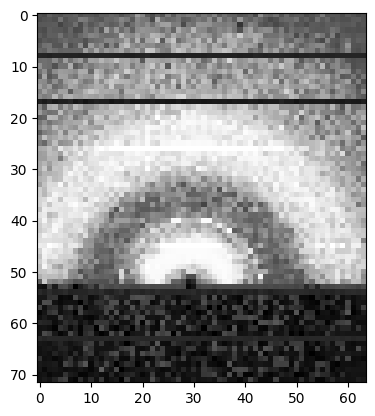

In [3]:
data_dir = './data/dataset'
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                                         labels=None, #if label='inferred', data_dir should be structured
                                                                         color_mode='rgb', #'grayscale',
                                                                         batch_size=batch_size,
                                                                         image_size=image_size,
                                                                         shuffle=True,
                                                                         seed=1,
                                                                         validation_split=0.2,
                                                                         subset='both',
                                                                         interpolation='lanczos5')    
    
# convert RGB to 3-channel grayscale to fullfil the diffusion model requirements
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x: (normalization_layer(x))).prefetch(buffer_size=32) 
val_dataset = val_dataset.map(lambda x: (normalization_layer(x))).prefetch(buffer_size=32)

plt.imshow(next(iter(train_dataset))[1])

## Model Configuration

In [4]:
from model import ModelConfig

model_config = ModelConfig(image_size=image_size, 
                           batch_size=batch_size,
                           widths=[32, 64, 96, 128])

## Training

Set training parameters

In [5]:
from model import DiffusionModel
from utils import TrainCallbacks

num_epochs = 5  # train for at least 50 epochs for good results
learning_rate = 1e-3
weight_decay = 1e-4
checkpoint_path = "checkpoints/diffusion_model"
nprint = 5 # print an example image every n epochs during training

2024-01-19 11:19:22.273987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Epoch 1/5
10/10 [==============================] - ETA: 0s - n_loss: 0.7348 - i_loss: 3.0247

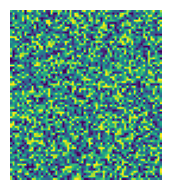

10/10 [==============================] - 19s 1s/step - n_loss: 0.7348 - i_loss: 3.0247 - val_n_loss: 0.7981 - val_i_loss: 2.8065 - val_kid: 1.9475
Epoch 2/5
10/10 [==============================] - 7s 666ms/step - n_loss: 0.4872 - i_loss: 1.8603 - val_n_loss: 0.7990 - val_i_loss: 3.4722 - val_kid: 1.8459
Epoch 3/5
10/10 [==============================] - 7s 568ms/step - n_loss: 0.3415 - i_loss: 1.0918 - val_n_loss: 0.7990 - val_i_loss: 3.4723 - val_kid: 1.8463
Epoch 4/5
10/10 [==============================] - 7s 669ms/step - n_loss: 0.3089 - i_loss: 0.8887 - val_n_loss: 0.7990 - val_i_loss: 3.4724 - val_kid: 1.8459
Epoch 5/5
10/10 [==============================] - 7s 634ms/step - n_loss: 0.2846 - i_loss: 0.7343 - val_n_loss: 0.7990 - val_i_loss: 3.4724 - val_kid: 1.8448


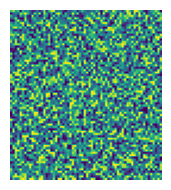

In [6]:
# create and compile the model
model = DiffusionModel(model_config)

model.compile(
    optimizer=keras.optimizers.experimental.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    #optimizer=keras.optimizers.experimental.SGD(learning_rate=0.1, clipnorm=1.0),
    loss=keras.losses.mean_absolute_error,
)

# save the best model based on the validation KID metric
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)


# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# save log history
txt_log = open('ddim_train_logs.txt', mode='wt', buffering=1)
train_callbacks = TrainCallbacks(model=model, log_fn=txt_log, n=nprint)

# run training and plot generated images periodically
# source code: https://github.com/keras-team/keras/blob/master/keras/engine/training.py
# printing training results, then validation 
training= model.fit(
            train_dataset.take(len(train_dataset)-1),  # drop the last batch
            epochs=num_epochs,   
            validation_data=val_dataset.take(len(val_dataset)-1),
            callbacks=[
                keras.callbacks.LambdaCallback(
                    on_epoch_end=lambda epoch, logs: train_callbacks.fn_epoch_end(epoch, logs),
                    on_train_end = lambda epoch: train_callbacks.fn_train_end()                
                ),
                checkpoint_callback,
            ],
)

## Continue training from the saved checkpoint

**Note:** the training process starts with a new optimizer each time. This is because the optimizer states are not saved in the checkpoint.  However, we can observe the loss continue going down as the new training starts.

Epoch 1/5
10/10 [==============================] - ETA: 0s - n_loss: 0.2578 - i_loss: 0.5994

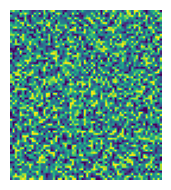

10/10 [==============================] - 8s 683ms/step - n_loss: 0.2578 - i_loss: 0.5994 - val_n_loss: 0.7990 - val_i_loss: 3.4725 - val_kid: 1.8424
Epoch 2/5
10/10 [==============================] - 7s 610ms/step - n_loss: 0.2523 - i_loss: 0.5537 - val_n_loss: 0.7990 - val_i_loss: 3.4725 - val_kid: 1.8421
Epoch 3/5
10/10 [==============================] - 6s 583ms/step - n_loss: 0.2457 - i_loss: 0.5345 - val_n_loss: 0.7990 - val_i_loss: 3.4725 - val_kid: 1.8427
Epoch 4/5
10/10 [==============================] - 6s 525ms/step - n_loss: 0.2419 - i_loss: 0.5102 - val_n_loss: 0.7990 - val_i_loss: 3.4724 - val_kid: 1.8431
Epoch 5/5
10/10 [==============================] - 6s 513ms/step - n_loss: 0.2370 - i_loss: 0.4988 - val_n_loss: 0.7990 - val_i_loss: 3.4724 - val_kid: 1.8433


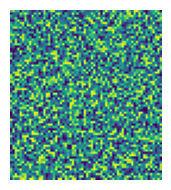

In [8]:
txt_log = open('ddim_train_logs.txt', mode='rt', buffering=1)
contents = "\n".join(map(lambda s: s.rstrip('\n'), txt_log.readlines()))
txt_log = open('ddim_train_logs.txt', mode='wt', buffering=1)
txt_log.write(contents+'\n')

train_callbacks = TrainCallbacks(model=model, log_fn=txt_log, n=nprint)

training2= model.fit(
            train_dataset.take(len(train_dataset)-1),  # drop the last batch
            epochs=num_epochs,   
            validation_data=val_dataset.take(len(val_dataset)-1),
            callbacks=[
                keras.callbacks.LambdaCallback(
                    on_epoch_end=lambda epoch, logs: train_callbacks.fn_epoch_end(epoch, logs),
                    on_train_end = lambda epoch: train_callbacks.fn_train_end()                  
                ),
                checkpoint_callback,
            ],
)